In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchkeras
import tushare as ts
%matplotlib inline

In [2]:
# pro = ts.pro_api('058f4da12dad296360396f4258a49d69dec6419e4f6db4bca17e8860')
# df = pro.ncov_num(level=2)
# df.to_csv('../data/02-covid_19/covid-19.csv', sep='\t')
# df.head()

In [3]:
df = pd.read_csv('../data/02-covid_19/covid-19.csv', sep='\t', index_col=0)
df.head()

,ann_date,area_name,parent_name,level,confirmed_num,suspected_num,confirmed_num_now,suspected_num_now,cured_num,dead_num
0,20200124,中国内地,中国,2,830,1072.0,NaN,NaN,34,25
1,20200125,中国内地,中国,2,1287,1965.0,NaN,NaN,38,41
2,20200126,中国内地,中国,2,1975,NaN,NaN,2684.0,49,56
3,20200127,中国内地,中国,2,2744,NaN,NaN,5794.0,51,80
4,20200128,中国内地,中国,2,4515,NaN,NaN,6973.0,60,106


In [4]:
df['ann_date'].min(), df['ann_date'].max()

(20200124, 20200322)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 0 to 58
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ann_date           59 non-null     int64  
 1   area_name          59 non-null     object 
 2   parent_name        59 non-null     object 
 3   level              59 non-null     int64  
 4   confirmed_num      59 non-null     int64  
 5   suspected_num      2 non-null      float64
 6   confirmed_num_now  45 non-null     float64
 7   suspected_num_now  57 non-null     float64
 8   cured_num          59 non-null     int64  
 9   dead_num           59 non-null     int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 5.1+ KB


In [6]:
df['ann_date'] = df['ann_date'].astype(str)

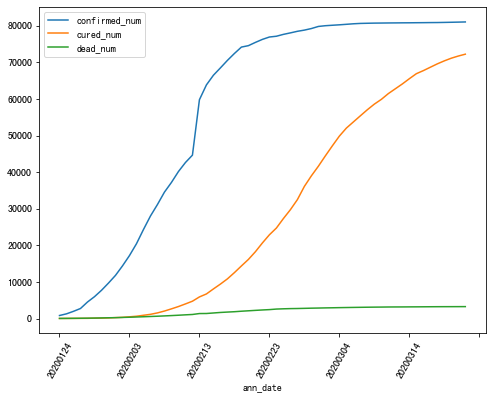

In [7]:
df.plot(x="ann_date", y=["confirmed_num", "cured_num", "dead_num"], figsize=(8, 6))
plt.xticks(rotation=60);

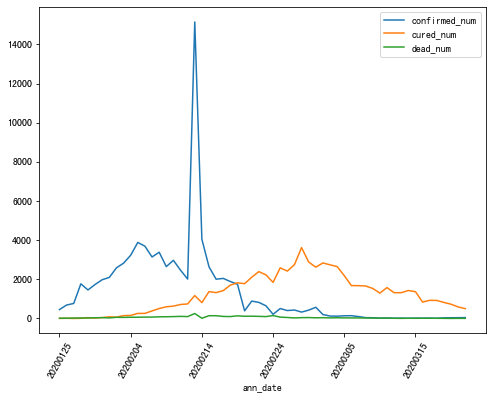

In [8]:
df = df[["ann_date", "confirmed_num", "cured_num", "dead_num"]]

dfdata = df.set_index("ann_date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("ann_date")

dfdiff.plot(x="ann_date", y=["confirmed_num","cured_num","dead_num"], figsize=(8, 6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("ann_date", axis=1).astype("float32")

In [9]:
dfdiff.head()

,confirmed_num,cured_num,dead_num
0,457.0,4.0,16.0
1,688.0,11.0,15.0
2,769.0,2.0,24.0
3,1771.0,9.0,26.0
4,1459.0,43.0,26.0


In [10]:
# 用某日前8天窗口数据作为输入预测该日数据
WINDOW_SIZE = 8

class Covid19Dataset(Dataset):

    def __len__(self):
        return len(dfdiff) - WINDOW_SIZE

    def __getitem__(self, i):
        x = dfdiff.loc[i: i + WINDOW_SIZE - 1, :]
        feature = torch.tensor(x.values)
        y = dfdiff.loc[i + WINDOW_SIZE, :]
        label = torch.tensor(y.values)
        return (feature, label)

ds_train = Covid19Dataset()

#数据较小，可以将全部训练数据放入到一个batch中，提升性能
dl_train = DataLoader(ds_train, batch_size = 38)

In [11]:
torch.random.seed()

class Block(nn.Module):
    def __init__(self):
        super(Block, self).__init__()

    def forward(self,x,x_input):
        x_out = torch.max((1 + x) * x_input[:, -1, :], torch.tensor(0.0))
        return x_out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3层lstm
        self.lstm = nn.LSTM(input_size=3, hidden_size=3, num_layers=5, batch_first=True)
        self.linear = nn.Linear(3, 3)
        self.block = Block()

    def forward(self,x_input):
        x = self.lstm(x_input)[0][:, -1, :]
        x = self.linear(x)
        y = self.block(x, x_input)
        return y

net = Net()
model = torchkeras.Model(net)
print(model)

model.summary(input_shape=(8, 3), input_dtype=torch.FloatTensor)

Model(
  (net): Net(
    (lstm): LSTM(3, 3, num_layers=5, batch_first=True)
    (linear): Linear(in_features=3, out_features=3, bias=True)
    (block): Block()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              LSTM-1                 [-1, 8, 3]             480
            Linear-2                    [-1, 3]              12
             Block-3                    [-1, 3]               0
Total params: 492
Trainable params: 492
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000092
Forward/backward pass size (MB): 0.000229
Params size (MB): 0.001877
Estimated Total Size (MB): 0.002197
----------------------------------------------------------------


In [12]:
def mspe(y_pred,y_true):
    err_percent = (y_true - y_pred)**2/(torch.max(y_true**2,torch.tensor(1e-7)))
    return torch.mean(err_percent)

model.compile(loss_func=mspe, optimizer=torch.optim.Adagrad(model.parameters(), lr = 0.1))

In [13]:
dfhistory = model.fit(100, dl_train, log_step_freq=10)

Start Training ...

================================================================================2021-06-15 18:05:59

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   1   | 0.582 |
+-------+-------+

================================================================================2021-06-15 18:05:59

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   2   | 0.449 |
+-------+-------+

================================================================================2021-06-15 18:05:59

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   3   | 0.449 |
+-------+-------+

================================================================================2021-06-15 18:05:59

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   4   | 0.444 |
+-------+-------+

================================================================================2021-06-15 18:06:00

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   5   | 0.443 |
+-------+-------+

===============


 +-------+-------+
| epoch |  loss |
+-------+-------+
|   47  | 0.212 |
+-------+-------+

================================================================================2021-06-15 18:06:01

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   48  | 0.212 |
+-------+-------+

================================================================================2021-06-15 18:06:01

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   49  | 0.212 |
+-------+-------+

================================================================================2021-06-15 18:06:01

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   50  | 0.212 |
+-------+-------+

================================================================================2021-06-15 18:06:01

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   51  | 0.212 |
+-------+-------+

================================================================================2021-06-15 18:06:01

 +-------+-------+
| epoch |  loss


 +-------+-------+
| epoch |  loss |
+-------+-------+
|   96  | 0.212 |
+-------+-------+

================================================================================2021-06-15 18:06:02

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   97  | 0.215 |
+-------+-------+

================================================================================2021-06-15 18:06:02

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   98  | 0.213 |
+-------+-------+

================================================================================2021-06-15 18:06:02

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   99  | 0.212 |
+-------+-------+

================================================================================2021-06-15 18:06:02

 +-------+-------+
| epoch |  loss |
+-------+-------+
|  100  | 0.212 |
+-------+-------+

================================================================================2021-06-15 18:06:02
Finished Training...


In [14]:
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()

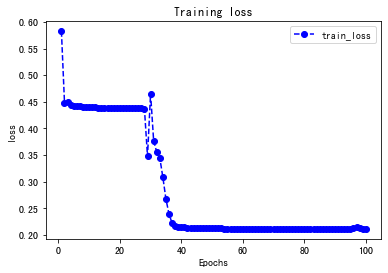

In [15]:
plot_metric(dfhistory,"loss")

In [16]:
# 使用dfresult记录现有数据以及此后预测的疫情数据
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
53,13.0,922.0,11.0
54,34.0,819.0,8.0
55,39.0,730.0,3.0
56,41.0,590.0,7.0
57,46.0,504.0,6.0


In [17]:
# 预测此后200天的新增走势,将其结果添加到dfresult中
for i in range(200):
    arr_input = torch.unsqueeze(torch.from_numpy(dfresult.values[-38:,:]),axis=0)
    arr_predict = model.forward(arr_input)

    dfpredict = pd.DataFrame(torch.floor(arr_predict).data.numpy(),
                columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)

In [18]:
dfresult.query("confirmed_num==0").head()

# 第50天开始新增确诊降为0，第45天对应3月10日，也就是5天后，即预计3月15日新增确诊降为0
# 注：该预测偏乐观

,confirmed_num,cured_num,dead_num
68,0.0,129.0,0.0
69,0.0,114.0,0.0
70,0.0,100.0,0.0
71,0.0,88.0,0.0
72,0.0,77.0,0.0


In [19]:
dfresult.query("cured_num==0").head()

# 第132天开始新增治愈降为0，第45天对应3月10日，也就是大概3个月后，即6月10日左右全部治愈。
# 注: 该预测偏悲观，并且存在问题，如果将每天新增治愈人数加起来，将超过累计确诊人数。

,confirmed_num,cured_num,dead_num
95,0.0,0.0,0.0
96,0.0,0.0,0.0
97,0.0,0.0,0.0
98,0.0,0.0,0.0
99,0.0,0.0,0.0


In [20]:
dfresult.query("dead_num==0").head()

# 第50天开始新增确诊降为0，第45天对应3月10日，也就是5天后，即预计3月15日新增确诊降为0
# 注：该预测偏乐观

,confirmed_num,cured_num,dead_num
61,13.0,308.0,0.0
62,9.0,272.0,0.0
63,6.0,240.0,0.0
64,4.0,212.0,0.0
65,3.0,187.0,0.0


In [21]:
print(model.net.state_dict().keys())

odict_keys(['lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'lstm.weight_ih_l2', 'lstm.weight_hh_l2', 'lstm.bias_ih_l2', 'lstm.bias_hh_l2', 'lstm.weight_ih_l3', 'lstm.weight_hh_l3', 'lstm.bias_ih_l3', 'lstm.bias_hh_l3', 'lstm.weight_ih_l4', 'lstm.weight_hh_l4', 'lstm.bias_ih_l4', 'lstm.bias_hh_l4', 'linear.weight', 'linear.bias'])


In [22]:
# 保存模型参数

torch.save(model.net.state_dict(), "../model/04-时间序列数据建模流程/model_parameter.pkl")

net_clone = Net()
net_clone.load_state_dict(torch.load("../model/04-时间序列数据建模流程/model_parameter.pkl"))
model_clone = torchkeras.Model(net_clone)
model_clone.compile(loss_func = mspe)

# 评估模型
model_clone.evaluate(dl_train)

{'val_loss': 0.21125565469264984}